In [12]:
import pandas as pd
from citipy import citipy
import numpy as np
import csv
from datetime import datetime as dt, timedelta
import json
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import gmaps 
from config import gkey
import scipy.stats as stats
from scipy.stats import linregress


#import data
weather = pd.read_json("ow.json") #1/1/2013-1/1/2020 hourly weather data
crime = pd.read_csv("../../crime.csv")

In [2]:
#Drop unneeded columns
drop_list = ['GEO_X', 'GEO_Y', 'DISTRICT_ID', 
             'REPORTED_DATE', 'LAST_OCCURRENCE_DATE',
            'INCIDENT_ID', 'OFFENSE_ID', 'OFFENSE_CODE_EXTENSION']
crime.drop(columns=drop_list, inplace=True)

In [3]:
#Clean up column names
crime = crime.rename(columns = {'OFFENSE_CODE':'Code', 
                               'OFFENSE_TYPE_ID':'Offense_Type', 
                               'INCIDENT_ADDRESS':'Address', 
                               'GEO_LON':'Lon',
                               'GEO_LAT':'Lat', 
                               'PRECINCT_ID':'Precint', 
                               'NEIGHBORHOOD_ID':'Neighborhood'})

# remove incorrect lat longs skewing data
crime = crime[crime["Lon"] <= -104.2]
crime = crime[crime["Lon"] >= -105.5]
crime = crime[crime["Lat"] >= 39.5]
crime = crime[crime["Lat"] <= 40.0]

In [4]:
#expand list from columns into new databases
weather_temp = (json_normalize(weather['main']))
weather_wind = json_normalize(weather['wind'])
weather_clouds = json_normalize(weather['clouds'])

In [5]:
#create new columns for desired fields from expanded list
weather_temp.head()
weather['Temp'] = weather_temp['temp']
weather['Temp Max'] = weather_temp['temp_max']
weather['Wind'] = weather_wind.speed
weather['Clouds'] = weather_clouds
#split date iso into columns, then delete unwanted columns 
weather[['Date','Hour', 'Trash', 'Trash2']] = weather.dt_iso.str.split(expand=True)
columns = ['wind', 'clouds', 'weather','main', 'timezone', 'snow', 'rain', 'dt', 'Trash', 'Trash2', 'dt_iso', 'lat', 'lon']
weather.drop(columns=columns, inplace=True)

In [6]:
# datetime date information within data, round to nearest hour
crime['Date'] = pd.to_datetime(crime['FIRST_OCCURRENCE_DATE'])
crime.drop(columns=['FIRST_OCCURRENCE_DATE'], inplace=True)
crime['Date'] = crime['Date'].dt.round('60min')
weather = weather.rename(columns = {'Date & Time':'Date'})

In [7]:
# remove incorrect lat longs skewing data
crime = crime[crime["Lon"] <= -104.2]
crime = crime[crime["Lon"] >= -105.5]
crime = crime[crime["Lat"] >= 39.5]
crime = crime[crime["Lat"] <= 40.0]

In [8]:
# merge crime and weather files by date
weather['Date']= pd.to_datetime(weather['Date'])
crime_weather = pd.merge(crime, weather, on='Date', how='left')

In [9]:
# Further data cleaning -EN

crime_weather = crime_weather.dropna(how = 'any')



# Interpretting our Data

In [53]:
# Digging in to understant/clean offense types - EN
crime_weather["Offense_Type"].value_counts()

# We should narrow in on offense category ID for the purpose of clarity

theft-items-from-vehicle        52421
traf-other                      47453
theft-of-motor-vehicle          37133
criminal-mischief-mtr-veh       26285
traffic-accident-hit-and-run    24630
                                ...  
theft-of-cable-services            24
drug-make-sell-other-drug          24
liquor-other-viol                  24
bomb-threat                        24
drug-marijuana-cultivation         24
Name: Offense_Type, Length: 156, dtype: int64

In [10]:
# clean crime category names
crime_weather = crime_weather[crime_weather["OFFENSE_CATEGORY_ID"] != 'all-other-crimes']
crime_weather['OFFENSE_CATEGORY_ID'] = crime_weather['OFFENSE_CATEGORY_ID'].replace(
    {'traffic-accident': 'Traffic Accident', 
     'larceny': 'Burglary/Theft', 
     'public-disorder': 'Public Disorder', 
     'theft-from-motor-vehicle': 'Burglary/Theft', 
     'drug-alcohol': 'Drug/Alcohol', 
     'auto-theft': 'Burglary/Theft', 
     'burglary': 'Burglary/Theft', 
     'other-crimes-against-persons': 'Crimes Against Persons', 
     'aggravated-assault': 'Aggravated Assault', 
     'white-collar-crime': 'White Collar Crime',  
     'robbery': 'Burglary/Theft', 
     'arson': 'Arson', 
     'murder': 'Murder'})
print(".........................................")
print(crime_weather["OFFENSE_CATEGORY_ID"].value_counts())

.........................................
Burglary/Theft            190660
Public Disorder            67835
Traffic Accident           49760
Crimes Against Persons     28490
Drug/Alcohol               25586
Aggravated Assault         15889
White Collar Crime         12917
Arson                       1080
Murder                       456
Name: OFFENSE_CATEGORY_ID, dtype: int64


In [15]:
crime_weather.to_csv('crime_weather.csv')


In [19]:
#groupby Neighborhood and set weight for heatmap = count of crimes within neighboorhood
groupn_mean_df = crime_weather.groupby("Neighborhood").mean()
count  = crime_weather.groupby("Neighborhood").count()['IS_CRIME'].astype(float)

#set locations equal to neighborhood lat and lon
locations = groupn_mean_df[["Lat", "Lon"]].astype(float)

#map crime in denver ny neighborhood
gmaps.configure(api_key=gkey)
fig = gmaps.figure()
heat_layer = gmaps.heatmap_layer(locations, weights=count, max_intensity=10000,
                                 point_radius = 15)
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))

# Which CRIME reports occurs the most in cold, warm, and hot temperatures?

In [55]:
cw_path = pd.read_csv('crime_weather.csv')
cw_orig = pd.DataFrame(cw_path)
crime_weather = pd.read_csv('crime_weather.csv')

In [56]:
# bin by temperature ranges
bins = [-50, 32, 50, 80, 120]
temp_names = ["Freezing","Cold","Warm","Hot"]
cw_orig["Temp Range"] = pd.cut(cw_orig['Temp'], bins, labels=temp_names)
#cw_orig.head()

In [57]:
# filter out traffic violations
iscrime_df = cw_orig[cw_orig['IS_CRIME']==1]
#iscrime_df.head()

In [58]:
# crime vs temp table 
crime_temp = iscrime_df[['OFFENSE_CATEGORY_ID','IS_CRIME','Temp Range']]
pivot_df = crime_temp.pivot_table(crime_temp, index='Temp Range', columns='OFFENSE_CATEGORY_ID', 
                                  aggfunc='count')
pivot_df

IS_CRIME                       \
OFFENSE_CATEGORY_ID Aggravated Assault Arson Burglary/Theft   
Temp Range                                                    
Freezing                          2149    82          28806   
Cold                              4205   244          53381   
Warm                              7969   631          91384   
Hot                               1566   123          17089   

                                                                \
OFFENSE_CATEGORY_ID Crimes Against Persons Drug/Alcohol Murder   
Temp Range                                                       
Freezing                              4195         3803     48   
Cold                                  7723         8381    118   
Warm                                 14037        11601    249   
Hot                                   2535         1801     41   

                                                        
OFFENSE_CATEGORY_ID Public Disorder White Collar Crime  
Temp Range                                              
Freezing                       9509               2475  
Cold                          19012               3908  
Warm                          33139               5513  
Hot                            6175               1021

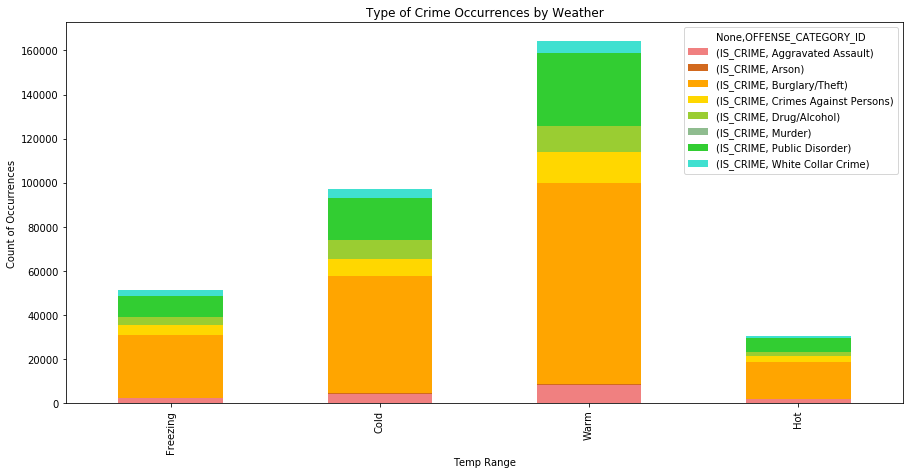

In [59]:
# stacked bar chart
colors = ['lightcoral','chocolate','orange','gold','yellowgreen','darkseagreen','limegreen','turquoise','teal','skyblue',
          'slategrey','mediumpurple','hotpink']
pivot_df.plot.bar(stacked=True, color=colors, figsize=(15,7))
plt.ylabel("Count of Occurrences")
plt.title("Type of Crime Occurrences by Weather")
plt.show()

# What TRAFFIC VIOL occurs the most in cold, warm, and hot temperatures?

In [61]:
# filter out crime violations
istraffic_df = cw_orig[cw_orig['IS_TRAFFIC']==1]


In [62]:
# traffic violation vs temp table 
traffic_temp = istraffic_df[['OFFENSE_CATEGORY_ID','IS_TRAFFIC','Temp Range']]
traffic_pivot = traffic_temp.pivot_table(traffic_temp, index='Temp Range', columns='OFFENSE_CATEGORY_ID', 
                                  aggfunc='count')
# stacked bar chart
# traffic_pivot.plot.bar(stacked=True, color=colors, figsize=(15,7))
# plt.ylabel("Count of Violations")
# plt.title("Type of Traffic Violations by Weather")
# plt.show()

# Proportionize the DataSet

In [63]:
#seperate data into crime dataframe and traffic datafram
is_crime = crime_weather.loc[crime_weather['IS_CRIME'] == 1]
is_traffic = crime_weather.loc[crime_weather['IS_TRAFFIC'] == 1]

In [64]:
#bin crime, traffic and weather data 
bins = [-10, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
groups = ['-10-0', '0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100']
is_crime['Temp Range'] = pd.cut(is_crime["Temp"], bins, labels=groups)
is_traffic['Temp Range'] = pd.cut(is_traffic["Temp"], bins, labels=groups)
weather['Temp Range'] = pd.cut(weather["Temp"].round(), bins, labels=groups)

#set new index and drop na
is_crime.set_index('Temp Range', inplace=True)
is_traffic.set_index('Temp Range', inplace=True)
weather.set_index('Temp Range', inplace=True)
weather.sort_index(inplace=True)
weather.dropna(inplace=True)

C:\Users\Deepak\Anaconda\envs\PythonData\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Deepak\Anaconda\envs\PythonData\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [65]:
##standardize data 
Ctemp_Plot = is_crime.groupby('Temp Range').count()
Ttemp_Plot = is_traffic.groupby('Temp Range').count()
weather_Count = weather.groupby('Temp Range').count()
Cstandardize = Ctemp_Plot['Code'] / weather_Count['Temp']
Tstandardize = Ttemp_Plot['Code'] / weather_Count['Temp']

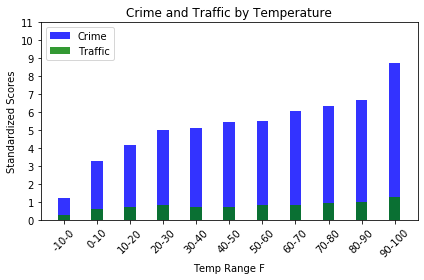

<Figure size 432x288 with 0 Axes>

In [66]:
#create bar chart containing crime and traffic by temp
fig, ax = plt.subplots()
bar_width = 0.35
opacity = 0.8

crime = plt.bar(Cstandardize.index, Cstandardize, bar_width,
alpha=opacity,
color='b',
label='Crime')

traffic = plt.bar(Tstandardize.index, Tstandardize, bar_width,
alpha=opacity,
color='g',
label='Traffic')

plt.xlabel('Temp Range F')
plt.ylabel('Standardized Scores')
plt.title('Crime and Traffic by Temperature')
plt.xticks(rotation = '45')
plt.yticks(range(0,12))
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

#save to png
plt.savefig("crime and traffic temp.png")

# Crime vs. Temp Correlation

The r-squared is: 0.18698590389891415


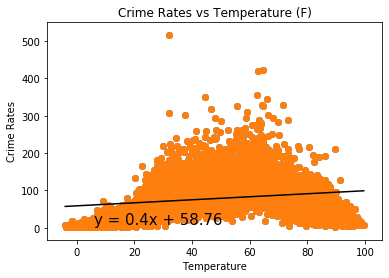

In [67]:
# Generate a group showing number of data points for date
grouptemp = crime_weather.groupby('Temp')

# Create a dataframe counting the number of data points for date
counttemp = pd.DataFrame(grouptemp['Temp'].count())

# Plot out temp versus crime rate
x_values = counttemp.index
y_values = counttemp.Temp
plt.scatter(x_values,y_values)
plt.xlabel('Temperature')
plt.ylabel('Crime Rates')
plt.title('Crime Rates vs Temperature (F)')

# Add the linear regression equation and line to plot
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"black")
plt.annotate(line_eq,(6,10),fontsize=15,color="black")

# Print out the r-squared value along with the plot.
print(f"The r-squared is: {rvalue}")
plt.savefig('tempcrimereg.png')
plt.show()

# Denver Neighborhood Crime

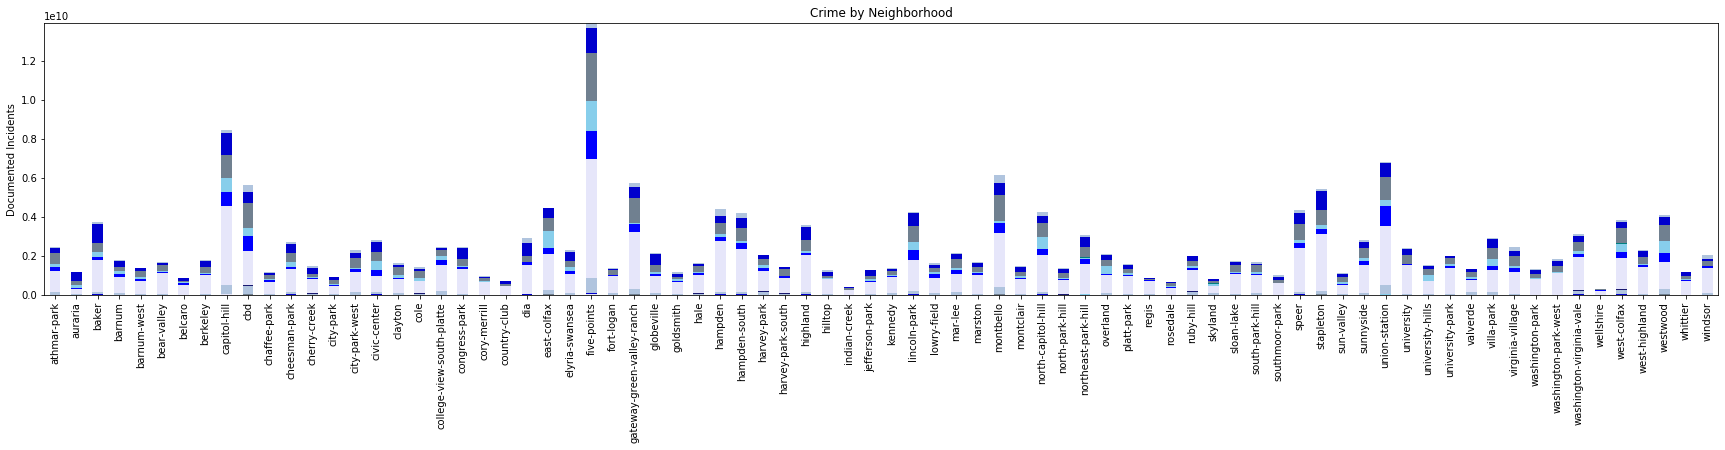

<Figure size 432x288 with 0 Axes>

In [68]:
# Playing with crime by neighborhood -EN

neighborhood_pivot = crime_weather.pivot_table(crime_weather, index='Neighborhood', columns='OFFENSE_CATEGORY_ID', 
                                  aggfunc='sum')
colors = ['mediumblue','lightsteelblue','midnightblue','lavender','blue','skyblue','teal','slategrey']
neighborhood_pivot.plot.bar(stacked=True, color=colors, figsize=(30,5), legend=None)
plt.xlabel("")
plt.ylabel("Documented Incidents")
plt.title("Crime by Neighborhood")
plt.show()
plt.savefig("all_neighborhoods.png")

In [28]:
# view top 10 neighborhoods on crime

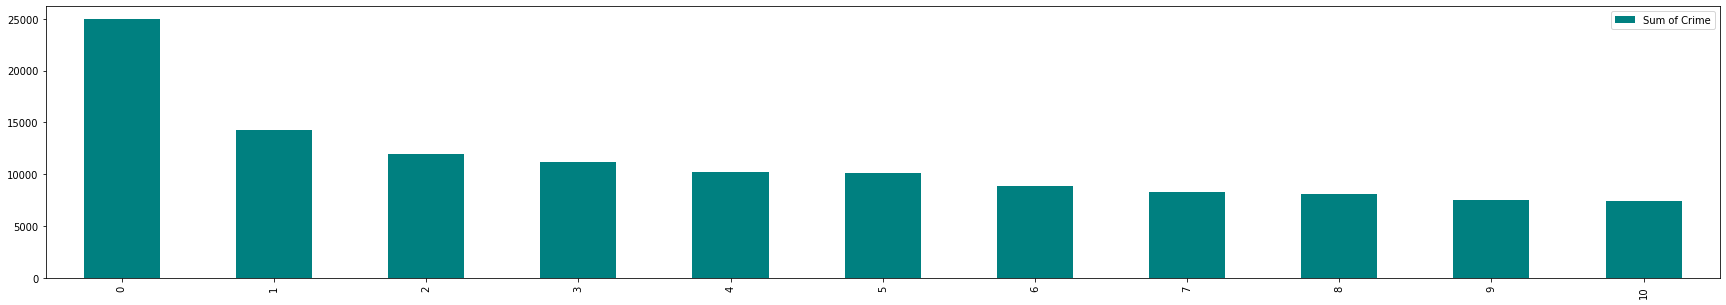

In [29]:
# Playing with crime by neighborhood -EN

groupn_count_df = crime_weather.groupby("Neighborhood").sum()
neighborhood_crime = groupn_count_df["IS_CRIME"].sort_values(ascending=False)

# I can't remember how to convert a groupby index back to numerical so...
crimesum = neighborhood_crime.tolist()
neighborhoods = neighborhood_crime.index.tolist()

# Data Frame with numerical index
ncrime = pd.DataFrame({"Neighborhoods" : neighborhoods, "Sum of Crime" : crimesum})
ncrime
topten_neighborhood_crime = ncrime.iloc[0:11, :]
labels = neighborhoods
topten_neighborhood_crime.plot.bar(color="teal", figsize=(30,5))
plt.savefig("topten_neighborhoods.png")

# Clouds on Crime

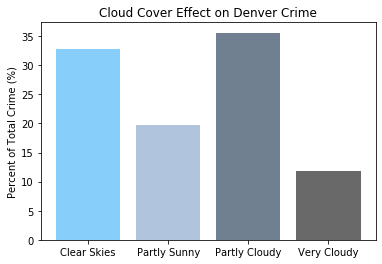

In [30]:
# What is the effect of cloud cover on Denver Crime? -EN

# Binned by cloud cover
bins = [0, 25, 50, 75, 100]
groups = ['Clear Skies', 'Partly Sunny', 'Partly Cloudy', 'Very Cloudy']
crime_weather["Cloud Bins"] = pd.cut(crime_weather["Clouds"], bins, labels=groups)

# Groupby to find sum of crime in each cloudcover bin
cloud_sum = crime_weather.groupby("Cloud Bins").sum()

# Percent of total crime in each cloud cover bin 
cloud_sum["Percent of Total"] = (cloud_sum["IS_CRIME"] / cloud_sum["IS_CRIME"].sum()) * 100

# Cloud cover bar plot
colors = ["lightskyblue", "lightsteelblue", "slategrey", "dimgrey" ]
plt.bar(groups, cloud_sum["Percent of Total"], color=colors, alpha=1, align="center",)
plt.ylabel("Percent of Total Crime (%)")
plt.title("Cloud Cover Effect on Denver Crime")

plt.savefig("cloudy_crime.png")

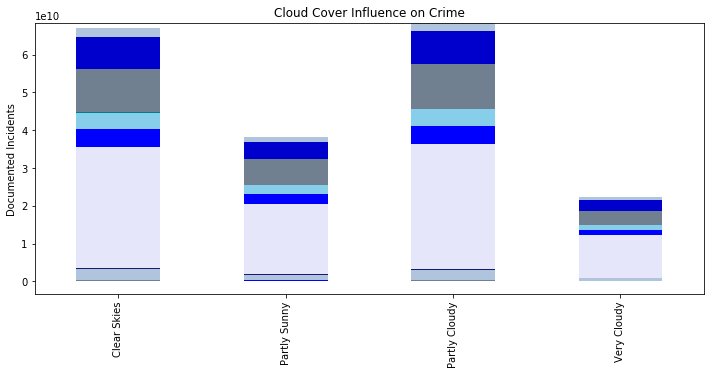

<Figure size 432x288 with 0 Axes>

In [31]:
# Playing with crime by cloud cover -EN

# Cloud pivot
cloud_pivot = crime_weather.pivot_table(crime_weather, index='Cloud Bins', columns='OFFENSE_CATEGORY_ID', 
                                  aggfunc='sum')

# Cloud cover stacked
colors = ['mediumblue','lightsteelblue','midnightblue','lavender','blue','skyblue','teal','slategrey']
cloud_pivot.plot.bar(stacked=True, color=colors, figsize=(12,5), legend=None)
plt.xlabel("")
plt.ylabel("Documented Incidents")
plt.title("Cloud Cover Influence on Crime")
plt.show()

plt.savefig("cloudy_crime_stacked.png")

# Wind

In [32]:
#create bins for Wind Ranges for Weather, Crime and traffic databases -KD
bins = [0, 10, 20, 30, 40, 51]
groups = ['0-10', '10-20', '20-30', '30-40', '40-50']
is_crime['Wind Range'] = pd.cut(is_crime["Wind"].round(), bins, labels=groups)

bins = [0, 10, 20, 30, 40, 51]
groups = ['0-10', '10-20', '20-30', '30-40', '40-50']
is_traffic['Wind Range'] = pd.cut(is_traffic["Wind"].round(), bins, labels=groups)

bins = [0, 10, 20, 30, 40, 51]
groups = ['0-10', '10-20', '20-30', '30-40', '40-50']
weather['Wind Range'] = pd.cut(weather["Wind"].round(), bins, labels=groups)

C:\Users\Deepak\Anaconda\envs\PythonData\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Deepak\Anaconda\envs\PythonData\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [33]:
#set variables and standardize data -KD
Cwind_Count = is_crime.groupby('Wind Range').count()
Wwind_Count = weather.groupby('Wind Range').count()
Cwind_stand = Cwind_Count['Temp'] / Wwind_Count['Temp']

Twind_Count = is_traffic.groupby('Wind Range').count()
Twind_stand = Twind_Count['Temp'] / Wwind_Count['Temp']

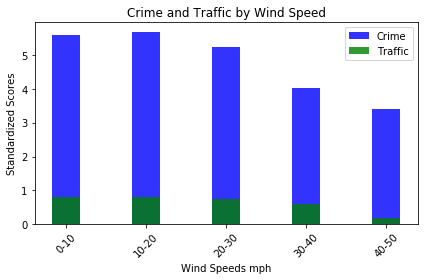

<Figure size 432x288 with 0 Axes>

In [34]:
#bar chart crime and traffic by wind -KD
fig, ax = plt.subplots()
bar_width = 0.35
opacity = 0.8

crime = plt.bar(Cwind_stand.index, Cwind_stand, bar_width,
alpha=opacity,
color='b',
label='Crime')

traffic = plt.bar(Twind_stand.index, Twind_stand, bar_width,
alpha=opacity,
color='g',
label='Traffic')

plt.xlabel('Wind Speeds mph')
plt.ylabel('Standardized Scores')
plt.title('Crime and Traffic by Wind Speed')
plt.xticks(rotation = '45')
plt.legend()

plt.tight_layout()
plt.show()

#save fig to png
plt.savefig("crime and traffic wind.png")

The r-squared is: 0.046764735889805


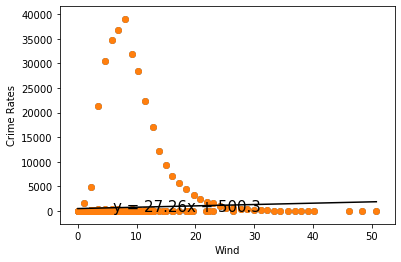

In [35]:
# Generate a group showing number of data points for date -NC
groupwind = iscrime_df.groupby('Wind')

# Create a dataframe counting the number of data points for date
countwind = pd.DataFrame(groupwind['Wind'].count())

# Plot out temp versus crime rate
x_values = countwind.index
y_values = countwind.Wind
plt.scatter(x_values,y_values)
plt.xlabel('Wind')
plt.ylabel('Crime Rates')

# Add the linear regression equation and line to plot
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"black")
plt.annotate(line_eq,(6,10),fontsize=15,color="black")

# Print out the r-squared value along with the plot.
print(f"The r-squared is: {rvalue}")
plt.savefig('tempcrimereg.png')
plt.show()

# Murder

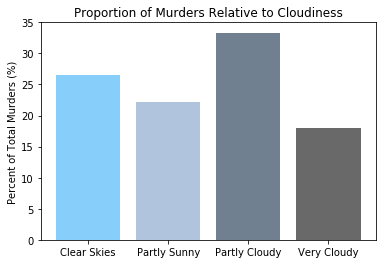

In [37]:
# Cloudy murders -EN
import numpy as np
bins = [0, 25, 50, 75, 100]
groups = ['Clear Skies', 'Partly Sunny', 'Partly Cloudy', 'Very Cloudy']
crime_weather["Cloud Bins"] = pd.cut(crime_weather["Clouds"], bins, labels=groups)
cloudy_murders = crime_weather[crime_weather["OFFENSE_CATEGORY_ID"] == "Murder"]

# Groupby to find sum of crime in each cloudcover bin
cloudy_murder_sum = cloudy_murders.groupby("Cloud Bins").sum()

# Percent of total crime in each cloud cover bin 
cloudy_murder_sum["Percent of Total"] = (cloudy_murder_sum["IS_CRIME"] / cloudy_murder_sum["IS_CRIME"].sum()) * 100

# Cloudy Murders Bar Plot
colors = ["lightskyblue", "lightsteelblue", "slategrey", "dimgrey" ]
plt.bar(groups, cloudy_murder_sum["Percent of Total"], color=colors, alpha=1, align="center")
plt.ylabel("Percent of Total Murders (%)")
plt.title("Proportion of Murders Relative to Cloudiness")

plt.savefig("cloudy_murder.png")

In [41]:
murder = is_crime[is_crime['OFFENSE_CATEGORY_ID']=="Murder"]
murder_df = pd.DataFrame(murder)
murder_df['Offense_Type'].value_counts()

homicide-other             336
homicide-family             48
traf-vehicular-homicide     24
homicide-negligent          24
homicide-police-by-gun      24
Name: Offense_Type, dtype: int64

In [44]:
##standardize data 
Ctemp_Plot = murder_df.groupby('Temp Range').count()
weather_Count = weather.groupby('Temp Range').count()
Cstandardize = Ctemp_Plot['OFFENSE_CATEGORY_ID'] / weather_Count['Temp']

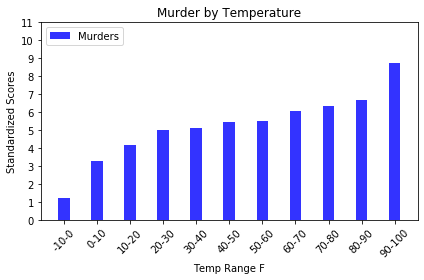

In [38]:
#bar chart murder by temp
#create bar chart containing crime and traffic by temp
fig, ax = plt.subplots()
bar_width = 0.35
opacity = 0.8

crime = plt.bar(Cstandardize.index, Cstandardize, bar_width,
alpha=opacity,
color='b',
label='Murders')


plt.xlabel('Temp Range F')
plt.ylabel('Standardized Scores')
plt.title('Murder by Temperature')
plt.xticks(rotation = '45')
plt.yticks(range(0,12))
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

# Arson

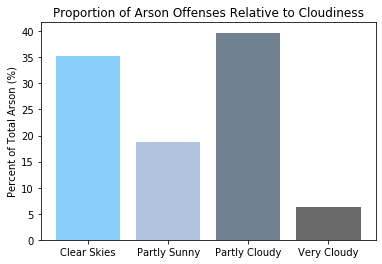

In [39]:
# Cloudy arson -EN

cloudy_arson = crime_weather[crime_weather["OFFENSE_CATEGORY_ID"] == "Arson"]

# Groupby to find sum of crime in each cloudcover bin
cloudy_arson_sum = cloudy_arson.groupby("Cloud Bins").sum()

# Percent of total crime in each cloud cover bin 
cloudy_arson_sum["Percent of Total"] = (cloudy_arson_sum["IS_CRIME"] / cloudy_arson_sum["IS_CRIME"].sum()) * 100

# Cloudy Murders Bar Plot
colors = ["lightskyblue", "lightsteelblue", "slategrey", "dimgrey" ]
plt.bar(groups, cloudy_arson_sum["Percent of Total"], color=colors, alpha=1, align="center",)
plt.ylabel("Percent of Total Arson (%)")
plt.title("Proportion of Arson Offenses Relative to Cloudiness")

plt.savefig("cloudy_arson.png")

# White Collar

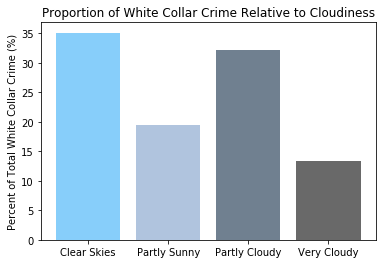

In [40]:
# Cloudy white collar crime -EN

cloudy_wcc = crime_weather[crime_weather["OFFENSE_CATEGORY_ID"] == "White Collar Crime"]

# Groupby to find sum of crime in each cloudcover bin
cloudy_wcc_sum = cloudy_wcc.groupby("Cloud Bins").sum()

# Percent of total crime in each cloud cover bin 
cloudy_wcc_sum["Percent of Total"] = (cloudy_wcc_sum["IS_CRIME"] / cloudy_wcc_sum["IS_CRIME"].sum()) * 100

# Cloudy Murders Bar Plot
colors = ["lightskyblue", "lightsteelblue", "slategrey", "dimgrey" ]
plt.bar(groups, cloudy_wcc_sum["Percent of Total"], color=colors, alpha=1, align="center",)
plt.ylabel("Percent of Total White Collar Crime (%)")
plt.title("Proportion of White Collar Crime Relative to Cloudiness")

plt.savefig("cloudy_whitecollarcrime.png")

In [69]:
#isolate seasons
years = ['2016', '2017', '2018', '2019']
summer1C = is_crime.loc[(is_crime['Date'] > '2015-06-01 00:00:00') & (is_crime['Date'] < '2015-09-01 00:00:00')]
winter1C = is_crime.loc[((is_crime['Date'] > '2015-12-01 00:00:00') & (is_crime['Date'] < '2015-12-31 00:00:00')) |
                       ((is_crime['Date'] > '2015-01-01 00:00:00') & (is_crime['Date'] < '2015-03-01 00:00:00'))]
fall1C = is_crime.loc[(is_crime['Date'] > '2015-09-02 00:00:00') & (is_crime['Date'] < '2015-11-30 00:00:00')]
spring1C = is_crime.loc[(is_crime['Date'] > '2015-03-02 00:00:00') & (is_crime['Date'] < '2015-06-01 00:00:00')]

#loop through list of years while creating database for each season containing all the years
for year in years:
    summer = is_crime.loc[(is_crime['Date'] > year + '-06-01 00:00:00') & (is_crime['Date'] < year +'-09-01 00:00:00')]
    fall = is_crime.loc[(is_crime['Date'] > year + '-09-02 00:00:00') & (is_crime['Date'] < year + '-11-30 00:00:00')]
    spring = is_crime.loc[(is_crime['Date'] > year + '-03-02 00:00:00') & (is_crime['Date'] < year + '-06-01 00:00:00')]
    winter = is_crime.loc[((is_crime['Date'] > year + '-12-01 00:00:00') & (is_crime['Date'] < year + '-12-31 00:00:00')) |
                          ((is_crime['Date'] < year + '-03-01 00:00:00') & (is_crime['Date'] > year + '-01-01 00:00:00'))]
    summer1C.merge(summer,  how='outer')
    spring1C.merge(spring, how='outer')
    fall1C.merge(fall, how='outer')
    winter1C.merge(winter, how='outer')
  

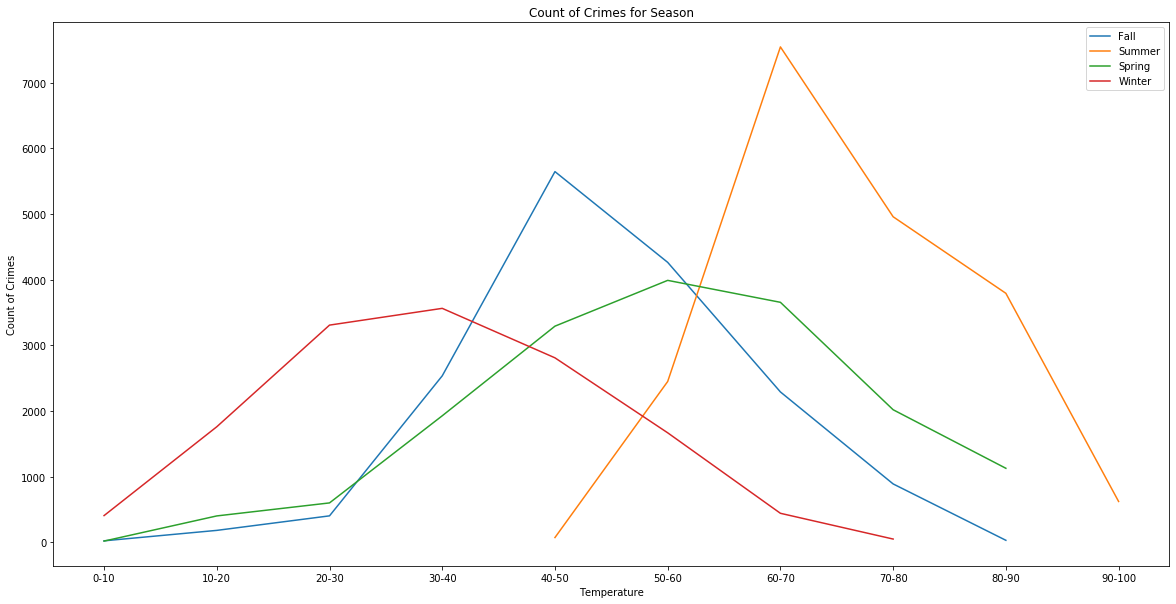

In [72]:
##standardize data for seasons
CStemp_Plot = summer1C.groupby('Temp Range').count()
CFtemp_Plot = fall1C.groupby('Temp Range').count()
CSptemp_Plot = spring1C.groupby('Temp Range').count()
Wtemp_Plot = winter1C.groupby('Temp Range').count()


xS_axis = [index for index in CStemp_Plot.index]
xF_axis = [index for index in CFtemp_Plot.index]
xSp_axis = [index for index in CSptemp_Plot.index]
xW_axis = [index for index in Wtemp_Plot.index]


#CStemp_Plot = CStemp_Plot.drop(columns='Wind Range')
CStemp_Plot.reset_index(inplace=True)
CStemp_Plot.set_index('Temp Range')
plt.figure(figsize=(20,10))
plt.plot(xSp_axis, CSptemp_Plot['Temp'])
plt.plot(xS_axis, CStemp_Plot['Temp'])
plt.plot(xF_axis, CFtemp_Plot['Temp'])
plt.plot(xW_axis, Wtemp_Plot['Temp'])
plt.legend(labels=['Fall', 'Summer', 'Spring', 'Winter'])
plt.title('Count of Crimes for Season')
plt.xlabel('Temperature')
plt.ylabel('Count of Crimes')
plt.savefig('crime by seasons.png')